In [1]:
import torchio as tio
import glob

import torch
import torch.nn as nn
import torch.nn.functional as F

import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the subjects in a list

dataTrainPath = "./training/"
dataTestPath = "./testing/"
subjects_list = []

for index, filename in enumerate(sorted(glob.iglob(dataTrainPath + 'patient*/patient*_frame*_gt.nii.gz'))):
    subject = nib.load(filename)
    subjects_list.append(subject)
for index, filename in enumerate(sorted(glob.iglob(dataTestPath + 'patient*/patient*_frame*_gt.nii.gz'))):
    subject = nib.load(filename)
    subjects_list.append(subject)

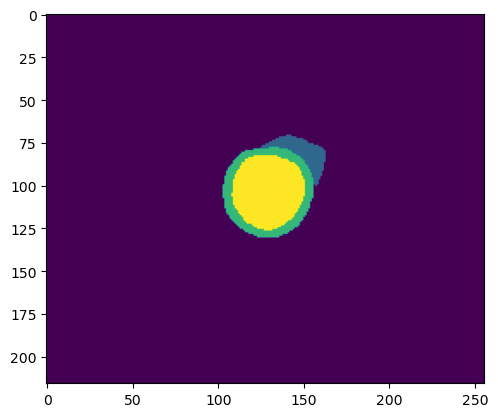

In [3]:
plt.imshow(subjects_list[0].get_fdata()[:,:,6])

In [4]:
from scipy.ndimage import center_of_mass
from scipy.ndimage import rotate

def center_rotate_seg(subject):
    '''
    This function takes a subject and :
        - centers the image on the LV cavity
        - rotates it so that the RV and LV cavities are aligned
    '''
    seg = subject.get_fdata()

    # Finding the center of LV cavity
    LV_mask = (seg == 3).astype(int)
    LV_center = center_of_mass(LV_mask)

    # Centering the image on the LV cavity
    seg = np.roll(seg, int(seg.shape[0]/2 - LV_center[0]), axis=0)
    seg = np.roll(seg, int(seg.shape[1]/2 - LV_center[1]), axis=1)

    # Finding the new center of LV cavity
    LV_mask = (seg == 3).astype(int)
    LV_center = center_of_mass(LV_mask)

    # Finding the center of RV cavity
    RV_mask = (seg == 1).astype(int)
    RV_center = center_of_mass(RV_mask)

    # Calculating the line between the two centers
    line = np.array(RV_center) - np.array(LV_center)

    # Finding the angle of rotation to align the LV and RV cavities
    angle = np.arctan2(line[0], line[1])

    # Rotating the image
    subject.data = rotate(seg, np.degrees(angle), axes = (0,1), reshape=False, order=0)
    subject.not_rotated_data = seg

In [5]:
# Rotate and center the segmentation masks

for i in range(len(subjects_list)):
    center_rotate_seg(subjects_list[i])

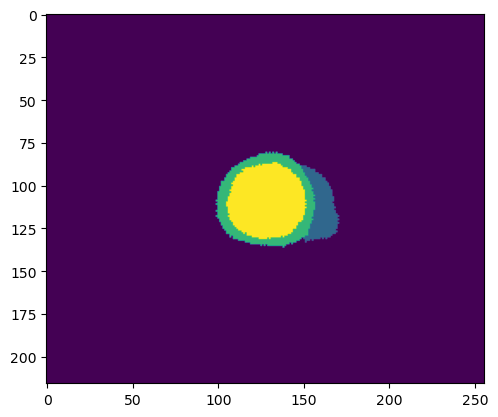

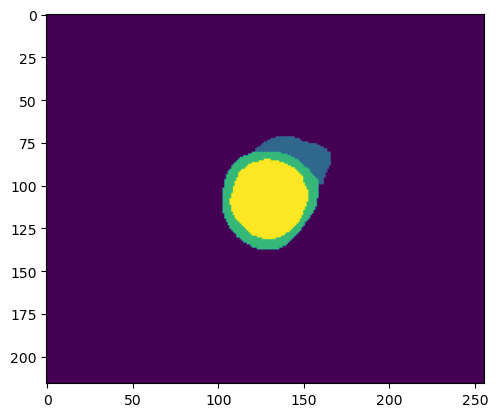

In [6]:
plt.imshow(subjects_list[0].data[:,:,5])
plt.show()
plt.imshow(subjects_list[0].not_rotated_data[:,:,5])

In [7]:
def crop_image(slice):
    '''
    This function takes a slice and crops the image to the smallest square, centered on the LV cavity, containing all the non-zero pixels
    '''
    # Finding the center of LV cavity
    LV_mask = (slice == 3).astype(int)
    LV_center = center_of_mass(LV_mask)

    # Finding the smallest square containing all the non-zero pixels
    x, y = np.nonzero(slice)
    if x.size == 0 or y.size == 0:
        return None
    else:
        x_min = np.min(x)
        x_max = np.max(x)
        y_min = np.min(y)
        y_max = np.max(y)
    min_square = max(x_max - LV_center[0], LV_center[0] - x_min, y_max - LV_center[1], LV_center[1] - y_min) + 5

    # Cropping the image
    if np.isnan(LV_center[0]) or np.isnan(LV_center[1]) or np.isnan(min_square):
        return None
    return slice[int(LV_center[0] - min_square):int(LV_center[0] + min_square), int(LV_center[1] - min_square):int(LV_center[1] + min_square)]

In [8]:
def crop_slices(subject):
    '''
    This function takes a subject and crops all its slices, then stores them in a list
    '''
    slices_list = []
    for i in range(subject.shape[2]):
        slice = subject[:,:,i]
        slice = crop_image(slice)
        if slice is not None:
            slices_list.append(slice)

    # Putting all the slices to the same size, centered on the LV cavity

    max_size = max([slice.shape[0] for slice in slices_list])
    for i in range(len(slices_list)):
        slice = slices_list[i]
        x, y = slice.shape
        pad_width = (max_size - x)//2
        slices_list[i] = np.pad(slice, pad_width=pad_width, mode='constant', constant_values=0)

    min_size = min(min([slice.shape[0] for slice in slices_list]), min([slice.shape[1] for slice in slices_list]))
    new_subject = np.zeros((min_size, min_size, len(slices_list)))
    for i in range(len(slices_list)):
        slice = slices_list[i]
        new_subject[:,:,i] = slice[:min_size, :min_size]

    return new_subject

In [9]:
for i in range(len(subjects_list)):
    subjects_list[i].data = crop_slices(subjects_list[i].data)
    subjects_list[i].not_rotated_data = crop_slices(subjects_list[i].not_rotated_data)
    subjects_list[i].new_shape = subjects_list[i].data.shape

c:\Users\charl\anaconda3\lib\site-packages\scipy\ndimage\_measurements.py:1534: RuntimeWarning: invalid value encountered in scalar divide
  results = [sum(input * grids[dir].astype(float), labels, index) / normalizer


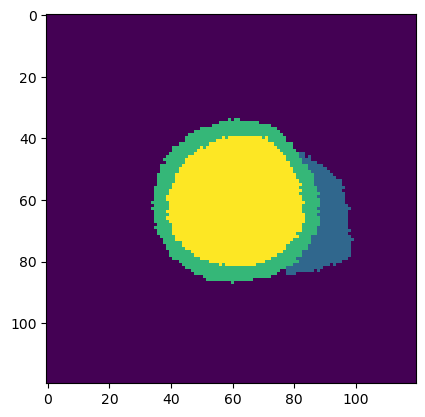

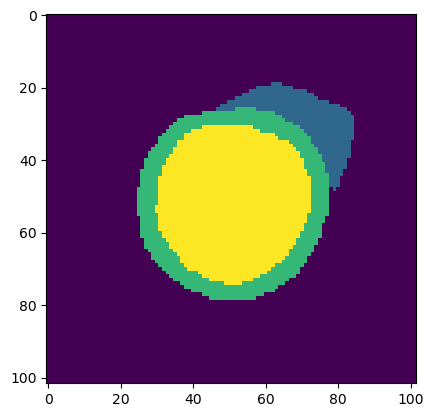

In [10]:
plt.imshow(subjects_list[0].data[:,:,5])
plt.show()
plt.imshow(subjects_list[0].not_rotated_data[:,:,5])

In [11]:
import torchvision.transforms as T

def resize_256(subject):
    '''
    This function takes a subject and resizes it to 256x256xZ, with Z the number of slices
    '''
    resize = T.Resize(size = (256, 256), interpolation=T.InterpolationMode.NEAREST)
    new_subject = np.zeros((256, 256, subject.shape[2]))
    for i in range(subject.shape[2]):
        slice_ = subject[:,:,i]
        slice_torch = torch.from_numpy(slice_)
        slice_torch = slice_torch.unsqueeze(0).unsqueeze(0)
        new_subject_torch = resize(slice_torch)
        new_subject_torch = new_subject_torch.squeeze(0).squeeze(0)
        new_subject[:,:,i] = new_subject_torch.numpy()
    return new_subject

c:\Users\charl\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] La procédure spécifiée est introuvable
  warn(f"Failed to load image Python extension: {e}")


In [12]:
for i in range(len(subjects_list)):
    subjects_list[i].data = resize_256(subjects_list[i].data)
    subjects_list[i].not_rotated_data = resize_256(subjects_list[i].not_rotated_data)
    subjects_list[i].new_shape = subjects_list[i].data.shape

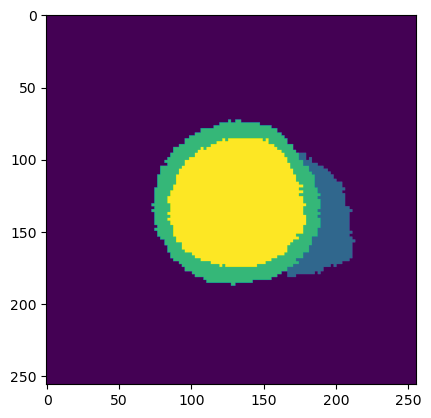

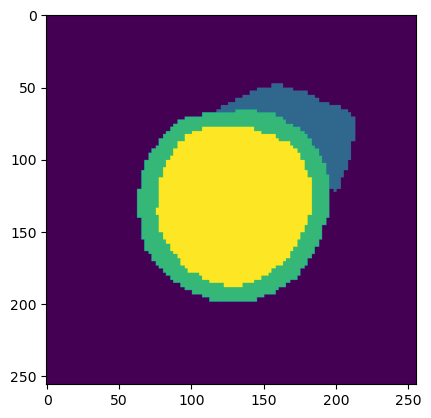

In [13]:
plt.imshow(subjects_list[0].data[:,:,5])
plt.show()
plt.imshow(subjects_list[0].not_rotated_data[:,:,5])

In [14]:
def four_channels(slice):
    '''
    This function takes a slice and returns a 3-channel slice, R channel being RV cavity, G channel being myocardium and B channel being LV cavity
    '''
    R = (slice == 1).astype(float)
    G = (slice == 2).astype(float)
    B = (slice == 3).astype(float)
    back = (slice == 0).astype(float)
    return np.stack((back, R, G, B), axis=2)

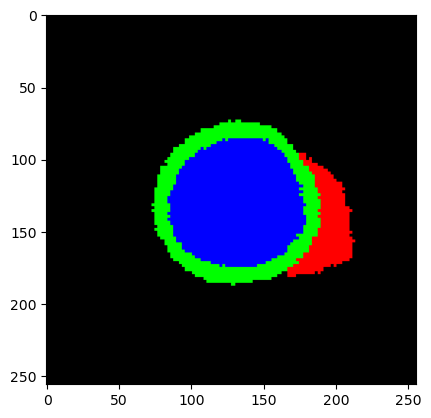

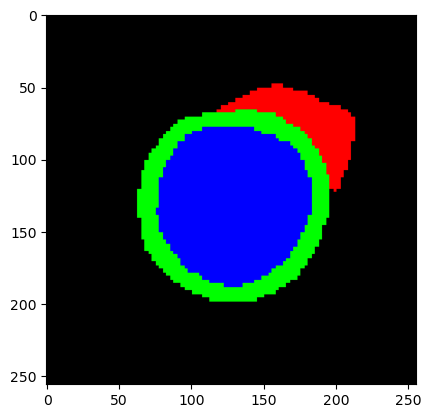

In [15]:
plt.imshow(four_channels(subjects_list[0].data[:,:,5])[:,:,1:])
plt.show()
plt.imshow(four_channels(subjects_list[0].not_rotated_data[:,:,5])[:,:,1:])

In [16]:
total_slices = 0
for i in range(len(subjects_list)):
    total_slices += subjects_list[i].new_shape[2]

subjects_torch = torch.zeros((total_slices, 4, 256, 256))

index = 0

for i in range(len(subjects_list)):
    subject = subjects_list[i].data
    for j in range(subject.shape[2]):
        slice = subject[:,:,j]
        slice = four_channels(slice)
        slice = torch.from_numpy(slice)
        slice = slice.permute(2, 0, 1)
        subjects_torch[index] = slice
        index += 1

In [17]:
total_slices_nr = 0
for i in range(len(subjects_list)):
    total_slices_nr += subjects_list[i].new_shape[2]

subjects_nr_torch = torch.zeros((total_slices_nr, 4, 256, 256))

index = 0

for i in range(len(subjects_list)):
    subject = subjects_list[i].not_rotated_data
    for j in range(subject.shape[2]):
        slice = subject[:,:,j]
        slice = four_channels(slice)
        slice = torch.from_numpy(slice)
        slice = slice.permute(2, 0, 1)
        subjects_nr_torch[index] = slice
        index += 1

In [18]:
# Creating the dataloader

from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split

dataset = TensorDataset(subjects_torch)
nr_dataset = TensorDataset(subjects_nr_torch)
trainset, valset, testset = random_split(dataset, [0.5, 0.2, 0.3])
trainloader = DataLoader(trainset, batch_size=100, shuffle=True)
valloader = DataLoader(valset, batch_size=100, shuffle=True)
testloader = DataLoader(testset, batch_size=100, shuffle=True)
nrloader = DataLoader(nr_dataset, batch_size=100, shuffle=True)

torch.Size([100, 4, 256, 256])


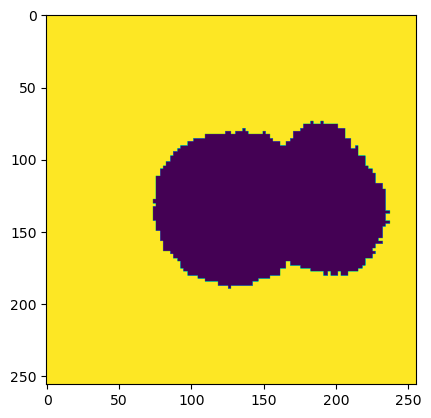

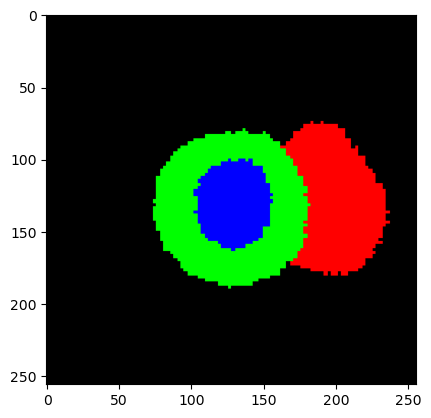

torch.Size([100, 4, 256, 256])


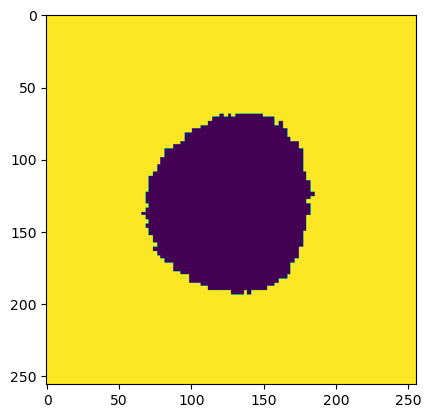

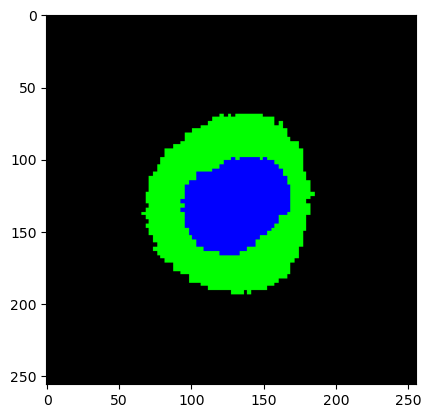

torch.Size([100, 4, 256, 256])


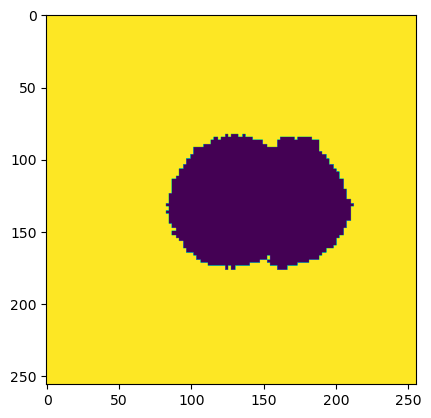

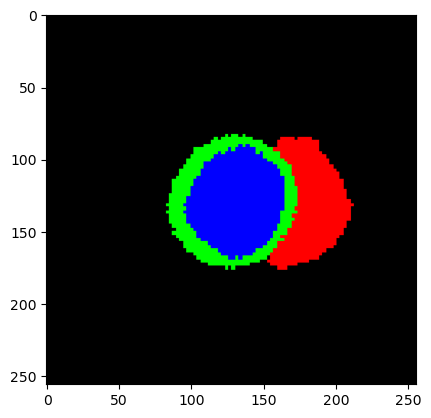

torch.Size([100, 4, 256, 256])


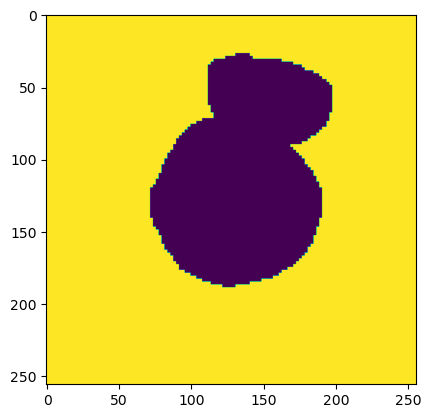

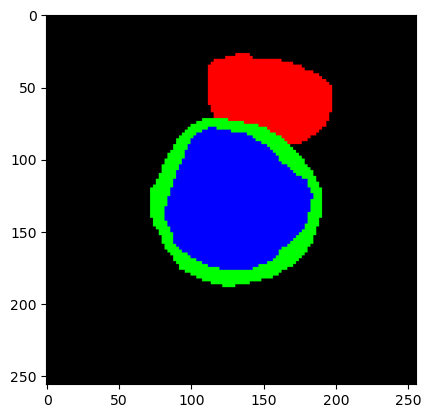

In [19]:
for batch in trainloader:
    print(batch[0].shape)
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,0])
    plt.show()
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,1:])
    plt.show()
    break

for batch in valloader:
    print(batch[0].shape)
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,0])
    plt.show()
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,1:])
    plt.show()
    break

for batch in testloader:
    print(batch[0].shape)
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,0])
    plt.show()
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,1:])
    plt.show()
    break

for batch in nrloader:
    print(batch[0].shape)
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,0])
    plt.show()
    plt.imshow(batch[0][0].permute(1, 2, 0)[:,:,1:])
    plt.show()
    break

### VAE Testing

In [20]:
device = "cuda:0"

In [21]:
import monai.losses as losses
from monai.metrics import DiceMetric

dice_metric = DiceMetric(include_background=False, reduction="mean", ignore_empty=False)

In [22]:
def four_channels_torch(slice):
    '''
    This function takes a slice and returns a 3-channel slice, R channel being RV cavity, G channel being myocardium and B channel being LV cavity
    '''
    R = (slice == 1).float().squeeze(0)
    G = (slice == 2).float().squeeze(0)
    B = (slice == 3).float().squeeze(0)
    back = (slice == 0).float().squeeze(0)
    output = torch.zeros((4, slice.shape[1], slice.shape[2]))
    output[0] = back
    output[1] = R
    output[2] = G
    output[3] = B
    return output

In [23]:
def calculate_dice_score(y_pred, y, metric = dice_metric):
    y_pred = torch.squeeze(y_pred)
    y_pred = torch.argmax(y_pred, dim=1, keepdim=True)
    y_four = torch.zeros_like(y)
    for i in range(y.shape[0]):
        y_four[i] = four_channels_torch(y_pred[i])
    y_pred = y_four
    dice_accuracy = metric(y_pred, y)
    return dice_accuracy

In [24]:
class VAE(nn.Module):
  def __init__(self, n_channels, batch_size, latent_dim):
    super(VAE, self).__init__()

    self.n_channels = n_channels
    self.batch_size = batch_size
    self.latent_dim = latent_dim
    self.final_conv = nn.Conv2d(self.n_channels, self.n_channels, kernel_size=3, stride=1, padding="same")
    self.linear_mu = nn.Linear(384*16*16, self.latent_dim)
    self.linear_sigma = nn.Linear(384*16*16, self.latent_dim)
    self.down_conv1 = self.down_conv_block(self.n_channels, 48)
    self.down_conv2 = self.down_conv_block(48, 96)
    self.down_conv3 = self.down_conv_block(96, 192)
    self.down_conv4 = self.down_conv_block(192, 384, last_activation=False)
    self.up_conv1 = self.up_conv_block(384, 192)
    self.up_conv2 = self.up_conv_block(192, 96)
    self.up_conv3 = self.up_conv_block(96, 48)
    self.up_conv4 = self.up_conv_block(48, self.n_channels)
    self.decoder_linear = nn.Linear(self.latent_dim, 384*16*16)

  def down_conv_block(self, in_channels, out_channels, kernel_size=3, last_activation=True):
    if last_activation :
      return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1),
                         nn.ELU(),
                         nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding="same"),
                         nn.ELU())
    else :
      return nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding=1),
                         nn.ELU(),
                         nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding="same"),)

  def up_conv_block(self, in_channels, out_channels):
    return nn.Sequential(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0),
                         nn.ELU(),
                         nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding="same"),
                         nn.ELU())
  
  def sampling(self, mu, log_var):
    std = torch.exp(0.5*log_var) # FILL IN CODE HERE
    eps = torch.randn_like(std) # FILL IN CODE HERE
    return mu + eps.mul(std) # return z sample

  def encoder(self, x):
    z = self.down_conv1(x)
    z = self.down_conv2(z)
    z = self.down_conv3(z)
    z = self.down_conv4(z)
    z = z.view(-1, 384*16*16)

    z_mu = self.linear_mu(z)
    z_sigma = self.linear_sigma(z)

    return z_mu, z_sigma

  def decoder(self, z):

    z = self.decoder_linear(z)
    z = z.view(-1, 384, 16, 16)

    z = self.up_conv1(z)
    z = self.up_conv2(z)
    z = self.up_conv3(z)
    z = self.up_conv4(z)

    return self.final_conv(z)

  
  def forward(self, x):
    z_mu, z_log_var = self.encoder(x)
    z = self.sampling(z_mu, z_log_var)
    return self.decoder(z), z_mu, z_log_var
  
  def loss_function(self,x, y, mu, log_var, beta):
    loss = losses.DiceCELoss(softmax=True, include_background=False, reduction="sum")
    reconstruction_error = loss(y,x)

    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(log_var))
    q = torch.distributions.Normal(mu, torch.exp(0.5*log_var))
    KLD = torch.distributions.kl_divergence(q, p).sum()

    return reconstruction_error + beta*KLD

In [25]:
import torch.optim as optim
model = VAE(4, 100, 32).to(device)
optimizer = optim.Adam(model.parameters(), lr=6e-5, weight_decay=1e-2)

In [26]:
#import model from state dict
model.load_state_dict(torch.load('model_beta_1000.pth'))

<All keys matched successfully>

In [27]:
def train_vae(vae_model, data_train_loader, data_val_loader, epoch, beta):
  train_loss = 0
  val_loss = 0
  vae_model.train()
  
  for batch_idx, data in enumerate(data_train_loader):
    optimizer.zero_grad()
    data = data[0].to(device)

    y, z_mu, z_log_var = vae_model.forward(data)
    loss_vae = vae_model.loss_function(data, y, z_mu, z_log_var, beta)
    loss_vae.backward()
    train_loss += loss_vae.item()
    optimizer.step()

    if(batch_idx%3 == 0):
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
      epoch, batch_idx * len(data), len(data_train_loader.dataset),
      100. * batch_idx / len(data_train_loader), loss_vae.item() / len(data)))
  vae_model.eval()
  for batch_idx, data in enumerate(data_val_loader):
    data = data[0].to(device)
    y, z_mu, z_log_var = vae_model.forward(data)
    loss_vae = vae_model.loss_function(data, y, z_mu, z_log_var, beta)
    val_loss += loss_vae.item()
    dice_score = calculate_dice_score(y, data)
  avg_train_loss = train_loss / len(data_train_loader.dataset)
  avg_val_loss = val_loss / len(data_val_loader.dataset)
  print('====> Epoch: {}, Average loss: {:.4f}, Val loss: {:.4f}, Dice score: {:.4f}'.format(epoch, avg_train_loss, avg_val_loss, dice_score.mean().item()))
  return avg_train_loss, avg_val_loss, dice_score


In [29]:
from copy import deepcopy

best_val_loss = np.inf
count = 0
best_model = deepcopy(model)
# train_losses = []
# val_losses = []
# M_dice_scores = []
# R_dice_scores = []
# G_dice_scores = []
# B_dice_scores = []

for epoch in range(0, 150):
  train_loss, val_loss, dice_score = train_vae(model, trainloader, valloader, epoch, 1000)
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  M_dice_scores.append(dice_score.mean().item())
  R_dice_scores.append(dice_score.mean(0)[0].item())
  G_dice_scores.append(dice_score.mean(0)[1].item())
  B_dice_scores.append(dice_score.mean(0)[2].item())

  if val_loss < best_val_loss :
    best_val_loss = val_loss
    best_model = deepcopy(model)
    count = 0
  else :
    count += 1

  if count == 5:
    break

Train Epoch: 0 [0/1393 (0%)]	Loss: 12507.233750
Train Epoch: 0 [300/1393 (21%)]	Loss: 11489.186250
Train Epoch: 0 [600/1393 (43%)]	Loss: 12009.742500
Train Epoch: 0 [900/1393 (64%)]	Loss: 12002.983750
Train Epoch: 0 [1200/1393 (86%)]	Loss: 12128.311250
====> Epoch: 0, Average loss: 11972.4696, Val loss: 12030.7993, Dice score: 0.7145
Train Epoch: 1 [0/1393 (0%)]	Loss: 11094.885000
Train Epoch: 1 [300/1393 (21%)]	Loss: 11945.540000
Train Epoch: 1 [600/1393 (43%)]	Loss: 11996.151250
Train Epoch: 1 [900/1393 (64%)]	Loss: 11656.885000
Train Epoch: 1 [1200/1393 (86%)]	Loss: 12395.508750
====> Epoch: 1, Average loss: 11941.5613, Val loss: 11903.2998, Dice score: 0.7564
Train Epoch: 2 [0/1393 (0%)]	Loss: 11763.420000
Train Epoch: 2 [300/1393 (21%)]	Loss: 11689.942500
Train Epoch: 2 [600/1393 (43%)]	Loss: 11927.771250
Train Epoch: 2 [900/1393 (64%)]	Loss: 11674.465000
Train Epoch: 2 [1200/1393 (86%)]	Loss: 12150.220000
====> Epoch: 2, Average loss: 11849.1163, Val loss: 11908.5835, Dice score:

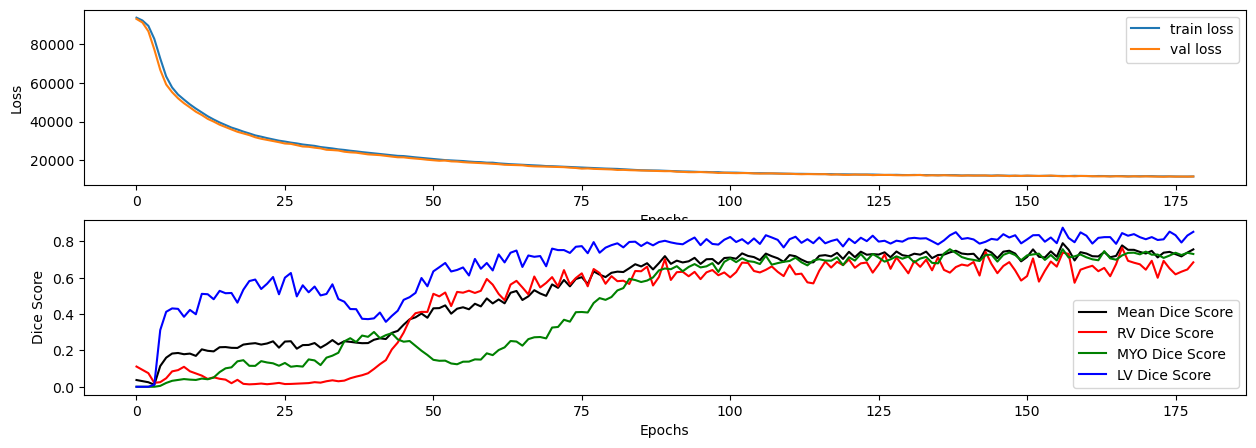

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(15, 5))

ax[0].plot(train_losses, label='train loss')
ax[0].plot(val_losses, label='val loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(M_dice_scores, label='Mean Dice Score', color='black')
ax[1].plot(R_dice_scores, label='RV Dice Score', color='red')
ax[1].plot(G_dice_scores, label='MYO Dice Score', color='green')
ax[1].plot(B_dice_scores, label='LV Dice Score', color='blue')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Dice Score')
ax[1].legend()
plt.show()

In [27]:
def display_slices(slices):
  c = slices.shape[0]
  new_slices = []
  figs, axs = plt.subplots(1,c, figsize=(20,5))
  dice_accuracy = 0
  for j in range(c):
    slices[j] = slices[j].softmax(dim=0)
    new_slices.append(torch.argmax(slices[j], dim=0))
    axs[j].imshow(four_channels(new_slices[j].cpu().detach().numpy())[:,:,1:])
  plt.show()

In [28]:
def generate_slices_dim(model, chosen_dimension, n_slices = 5):
  '''
  This function takes a trained model and a dimension of the latent space and generates n_slices slices exploring this chosen dimension'''
  z = torch.zeros(n_slices, model.latent_dim).to(device)
  z[:,chosen_dimension] = torch.tensor(np.linspace(-3, 3, n_slices)).to(device)
  slices = model.decoder(z)
  return slices, torch.var(slices).item()

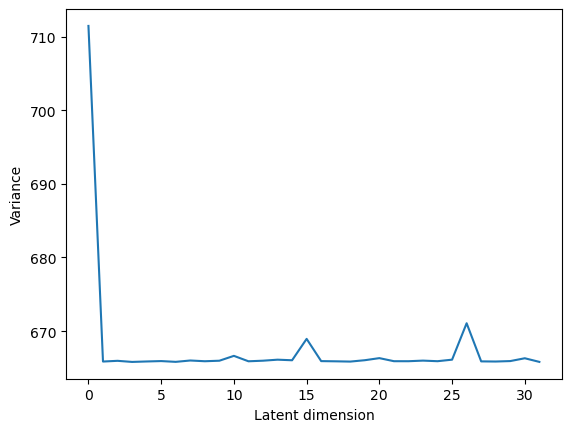

The 6 latent dimensions with the highest variance are (from highest variation to lowest variation):
[ 0 26 15 10 20 30]


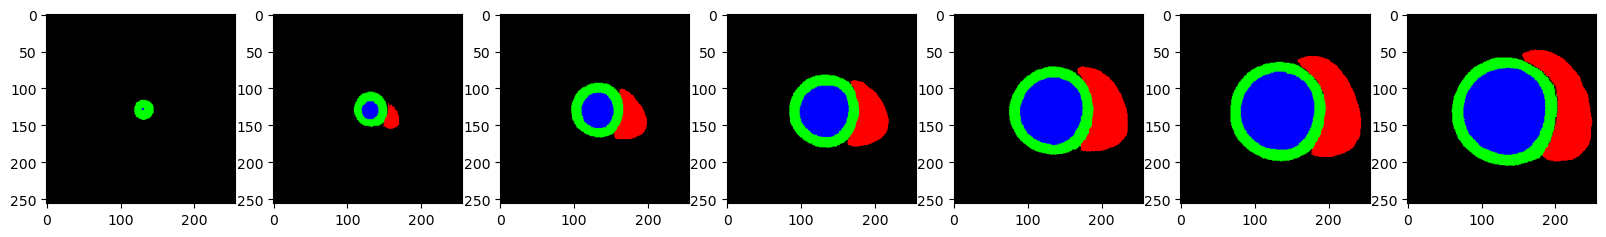

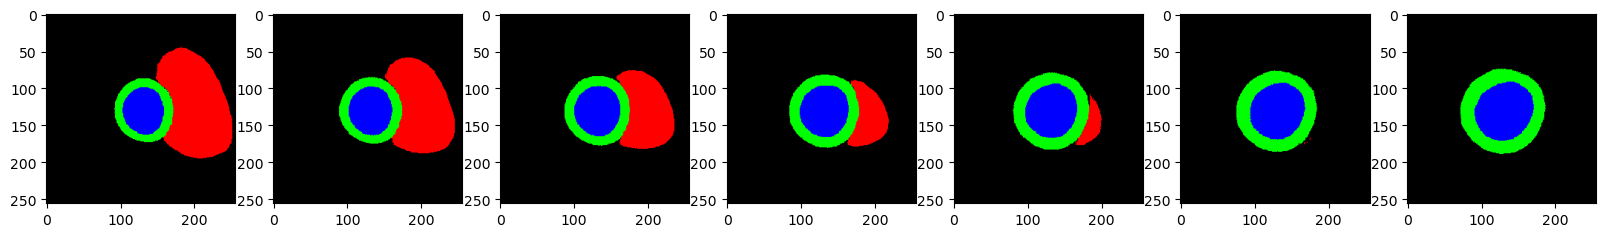

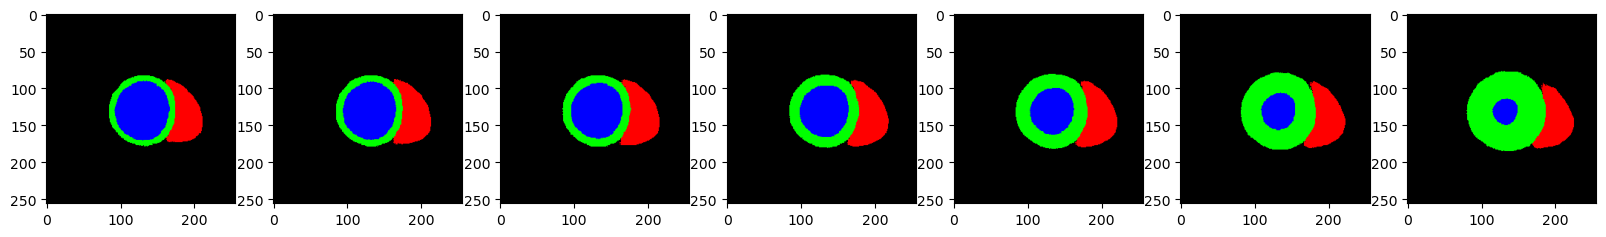

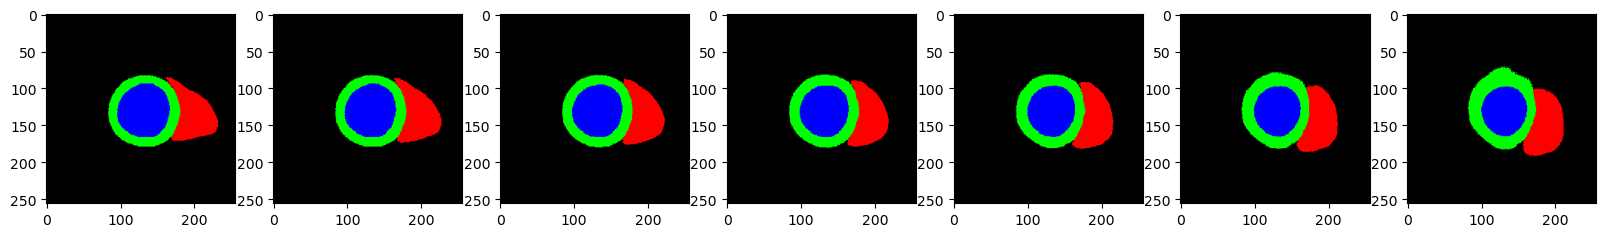

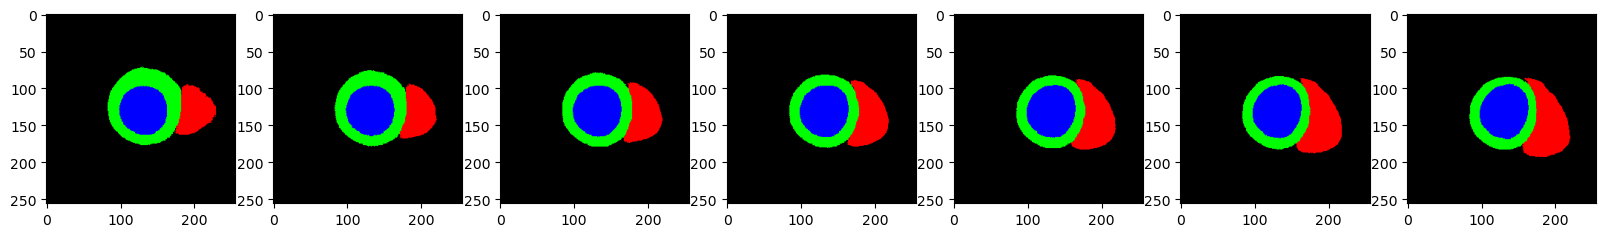

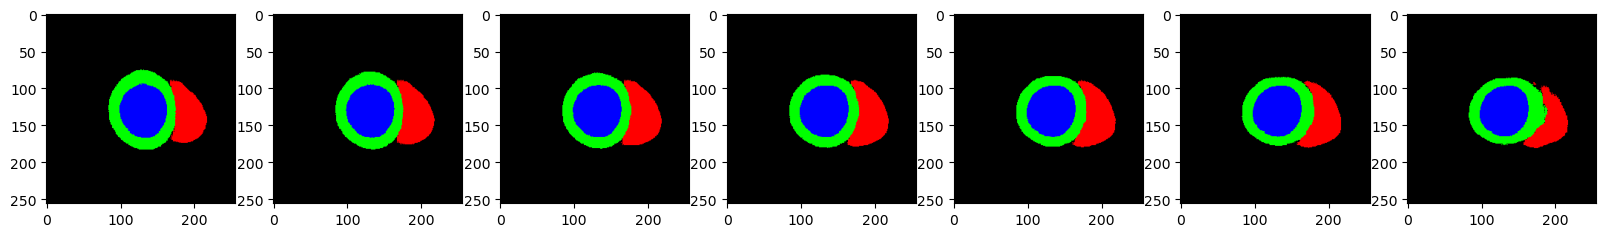

In [82]:
dice_scores = []
variances = []
z_base = torch.zeros(50, model.latent_dim).to(device)
slices_base = model.decoder(z_base)
slices_base = torch.squeeze(slices_base)
slices_base = torch.argmax(slices_base, dim=1, keepdim=True)
slices_four = torch.zeros((50, 4, 256, 256)).to(device)
for i in range(50):
    slices_four[i] = four_channels_torch(slices_base[i])
slices_base = slices_four

for i in range(32):
    slices_generated, variance = generate_slices_dim(model, i, n_slices = 50)
    variances.append(variance)
    dice_score = calculate_dice_score(slices_generated, slices_base)
    dice_scores.append(dice_score.mean().item())
    

plt.plot(variances)
plt.xlabel('Latent dimension')
plt.ylabel('Variance')
plt.show()
print("The 6 latent dimensions with the highest variance are (from highest variation to lowest variation):")
print(np.flip(np.argsort(variances)[-6:]))

for i in np.flip(np.argsort(variances)[-6:]):
    slices_generated, variance = generate_slices_dim(model, i, n_slices = 7)
    display_slices(slices_generated)

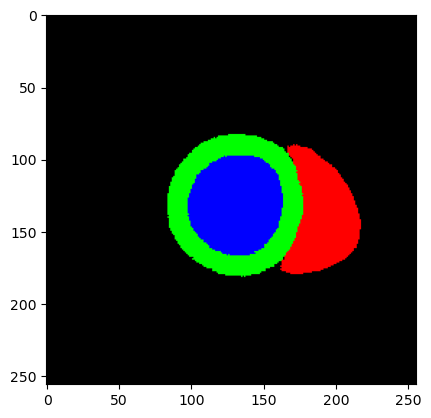

In [149]:
plt.imshow(slices_base[0].permute(1, 2, 0)[:,:,1:].cpu().detach().numpy())

In [83]:
print("The 6 latent dimensions with the highest variance are (from highest variation to lowest variation):")
print(np.flip(np.argsort(dice_scores)[-6:]))
print("The variances of these 6 latent dimensions are:")
print(np.flip(np.sort(variances)[-6:]))

The 6 latent dimensions with the highest variance are (from highest variation to lowest variation):
[24 23 27 11  6  9]
The variances of these 6 latent dimensions are:
[711.44726562 671.06854248 668.94622803 666.640625   666.33209229
 666.31518555]


In [84]:
print("The 6 latent dimensions with the lowest Dice score are (from lowest to highest, so from higher variation to lowest variation):")
print(np.argsort(dice_scores)[:6])
print("The dice scores are:")
print(np.sort(dice_scores)[:6])

The 6 latent dimensions with the lowest Dice score are (from lowest to highest, so from higher variation to lowest variation):
[ 0 26 15 20 10 19]
The dice scores are:
[0.3845048  0.72456831 0.85207504 0.92271405 0.93223512 0.94181824]


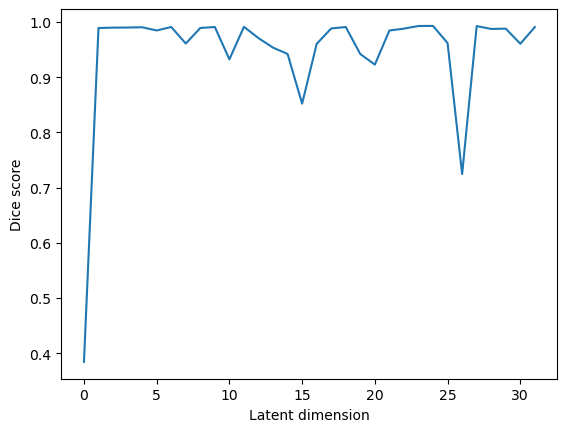

The 6 latent dimensions with the lowest dice score are (from lowest to highest, so from higher variation to lowest variation):
[ 0 26 15 20 10 19]


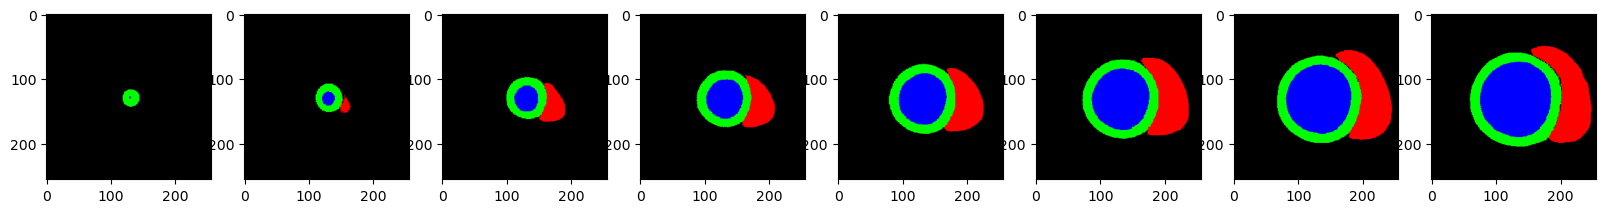

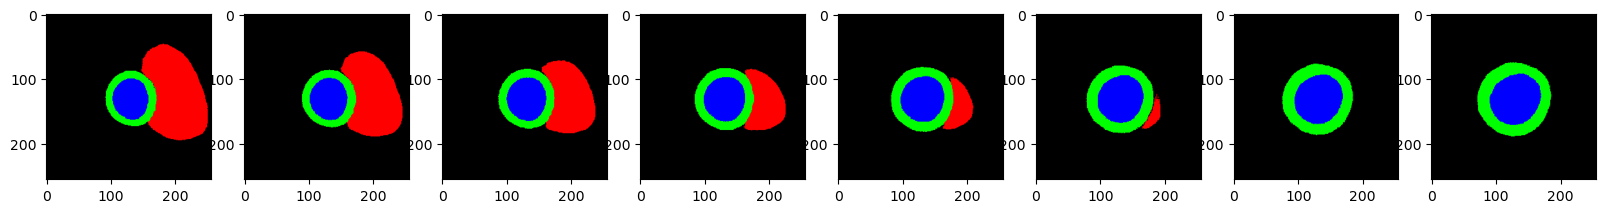

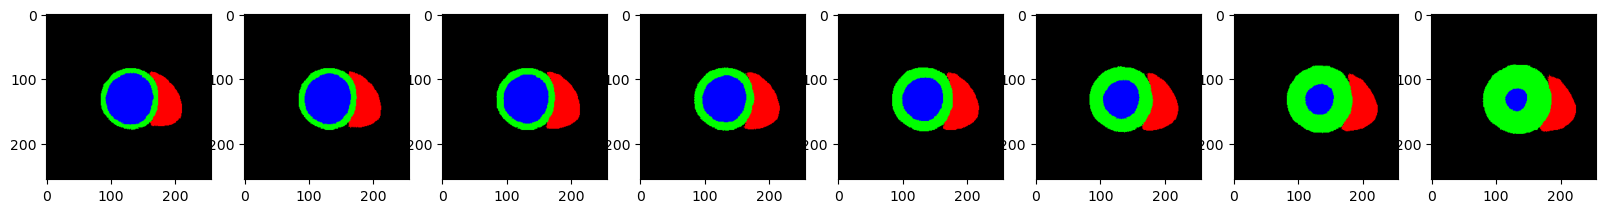

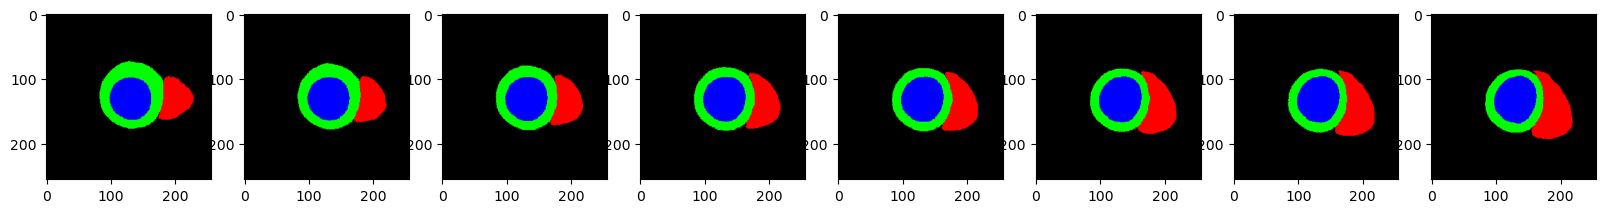

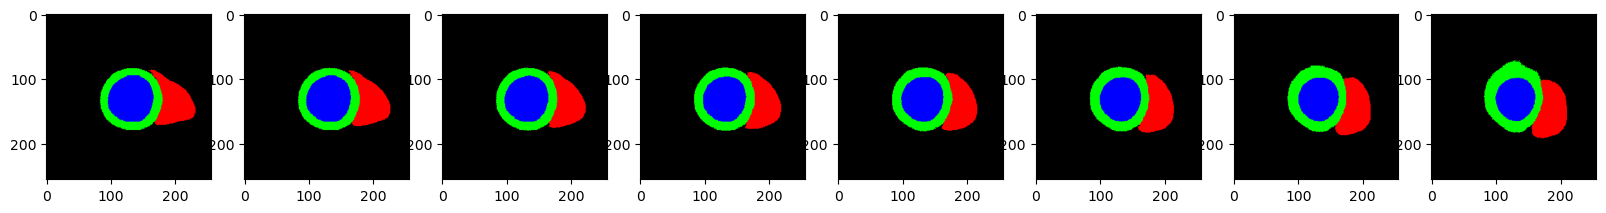

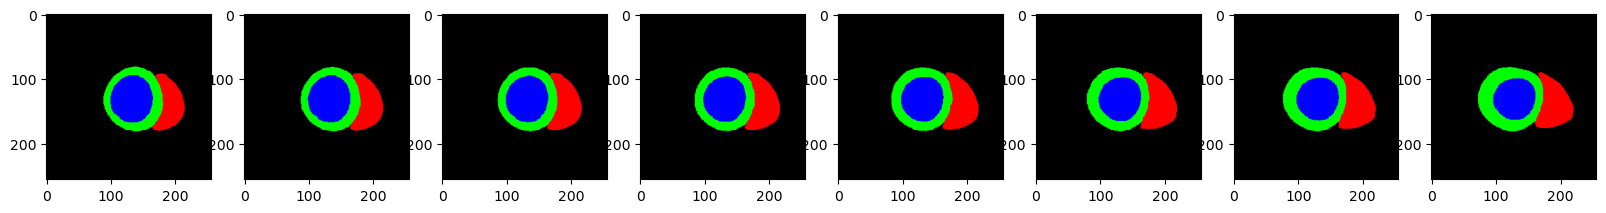

In [86]:
plt.plot(dice_scores)
plt.xlabel('Latent dimension')
plt.ylabel('Dice score')
plt.show()
print("The 6 latent dimensions with the lowest dice score are (from lowest to highest, so from higher variation to lowest variation):")
print(np.argsort(dice_scores)[:6])

for i in np.argsort(dice_scores)[:6]:
    slices_generated, variance = generate_slices_dim(model, i, n_slices = 8)
    display_slices(slices_generated)

Dim 0 -> LV + MYO size   
Dim 26 -> RV shape   
Dim 15 -> MYO thickness   
Dim 20 -> LV centering relative to MYO center on the vertical axis   
Dim 10 -> LV + MYO size on horizontal axis     
Dim 19 -> LV centering relative to MYO center on the horizontal axis   
Dim 30 -> LV + MYO size on vertical axis   

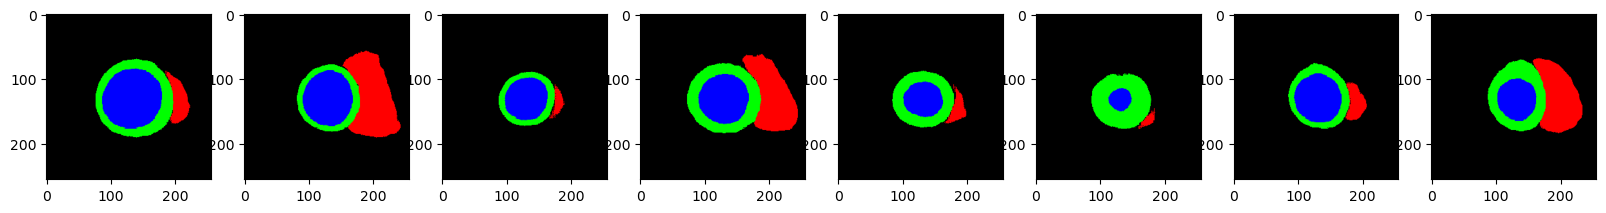

In [79]:
def generate_slices(model, n_slices = 5):
  eps = torch.randn(n_slices, model.latent_dim).to(device)
  slices_generated = model.decoder(eps)
  return slices_generated

slices_generated = generate_slices(model, n_slices = 8)
display_slices(slices_generated)

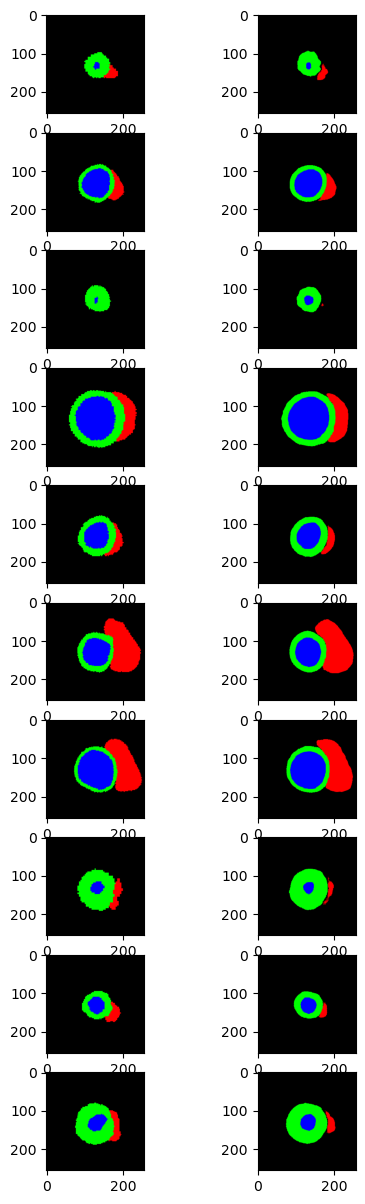

Dice score :  0.8080354332923889


In [49]:
for batch in testloader:
  model.eval()
  data = batch[0][:10]
  fig, axs = plt.subplots(10, 2, figsize=(5,15))
  data_model = data.to(device)
  y, z_mu, z_log_var = model.forward(data_model)
  dice_accuracy = calculate_dice_score(y, data_model, dice_metric)
  y_print = torch.squeeze(y)
  # make y_print between 0 and 1
  y_print = torch.argmax(y_print, dim=1, keepdim=True)
  y_print = y_print.permute(0, 2, 3, 1).squeeze(3).cpu().detach().numpy()
  for i in range(10):
    axs[i,0].imshow(data[i].permute(1, 2, 0)[:,:,1:])
    y_print_ = four_channels(y_print[i])
    axs[i,1].imshow(y_print_[:,:,1:])
  plt.show()
  print("Dice score : ", dice_accuracy.mean().item())
  break

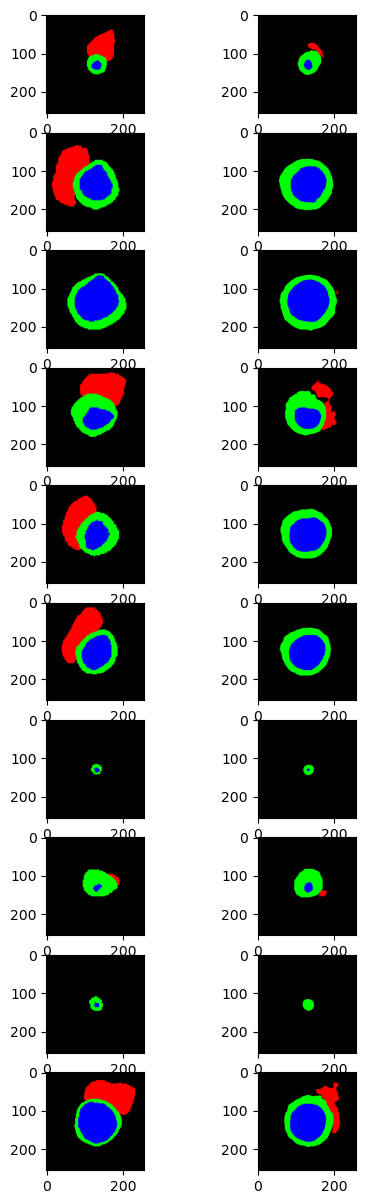

Dice score :  0.5796879529953003


In [50]:
for batch in nrloader:
  model.eval()
  data = batch[0][:10]
  fig, axs = plt.subplots(10, 2, figsize=(5,15))
  data_model = data.to(device)
  y, z_mu, z_log_var = model.forward(data_model)
  dice_accuracy = calculate_dice_score(y, data_model, dice_metric)
  y_print = torch.squeeze(y)
  # make y_print between 0 and 1
  y_print = torch.argmax(y_print, dim=1, keepdim=True)
  y_print = y_print.permute(0, 2, 3, 1).squeeze(3).cpu().detach().numpy()
  for i in range(10):
    axs[i,0].imshow(data[i].permute(1, 2, 0)[:,:,1:])
    y_print_ = four_channels(y_print[i])
    axs[i,1].imshow(y_print_[:,:,1:])
  plt.show()
  print("Dice score : ", dice_accuracy.mean().item())
  break

In [71]:
torch.save(best_model.state_dict(), 'okay_model_beta_1000.pth')

In [151]:
# fitting a gaussian distribution to the latent space
torch.cuda.empty_cache()
z_list = []
for batch in trainloader:
  model.eval()
  data = batch[0]
  data_model = data.to(device)
  y, z_mu, z_log_var = model.forward(data_model)
  z = model.sampling(z_mu, z_log_var)
  z_list.append(z.detach().cpu().numpy())

z_list = np.concatenate(z_list, axis=0)

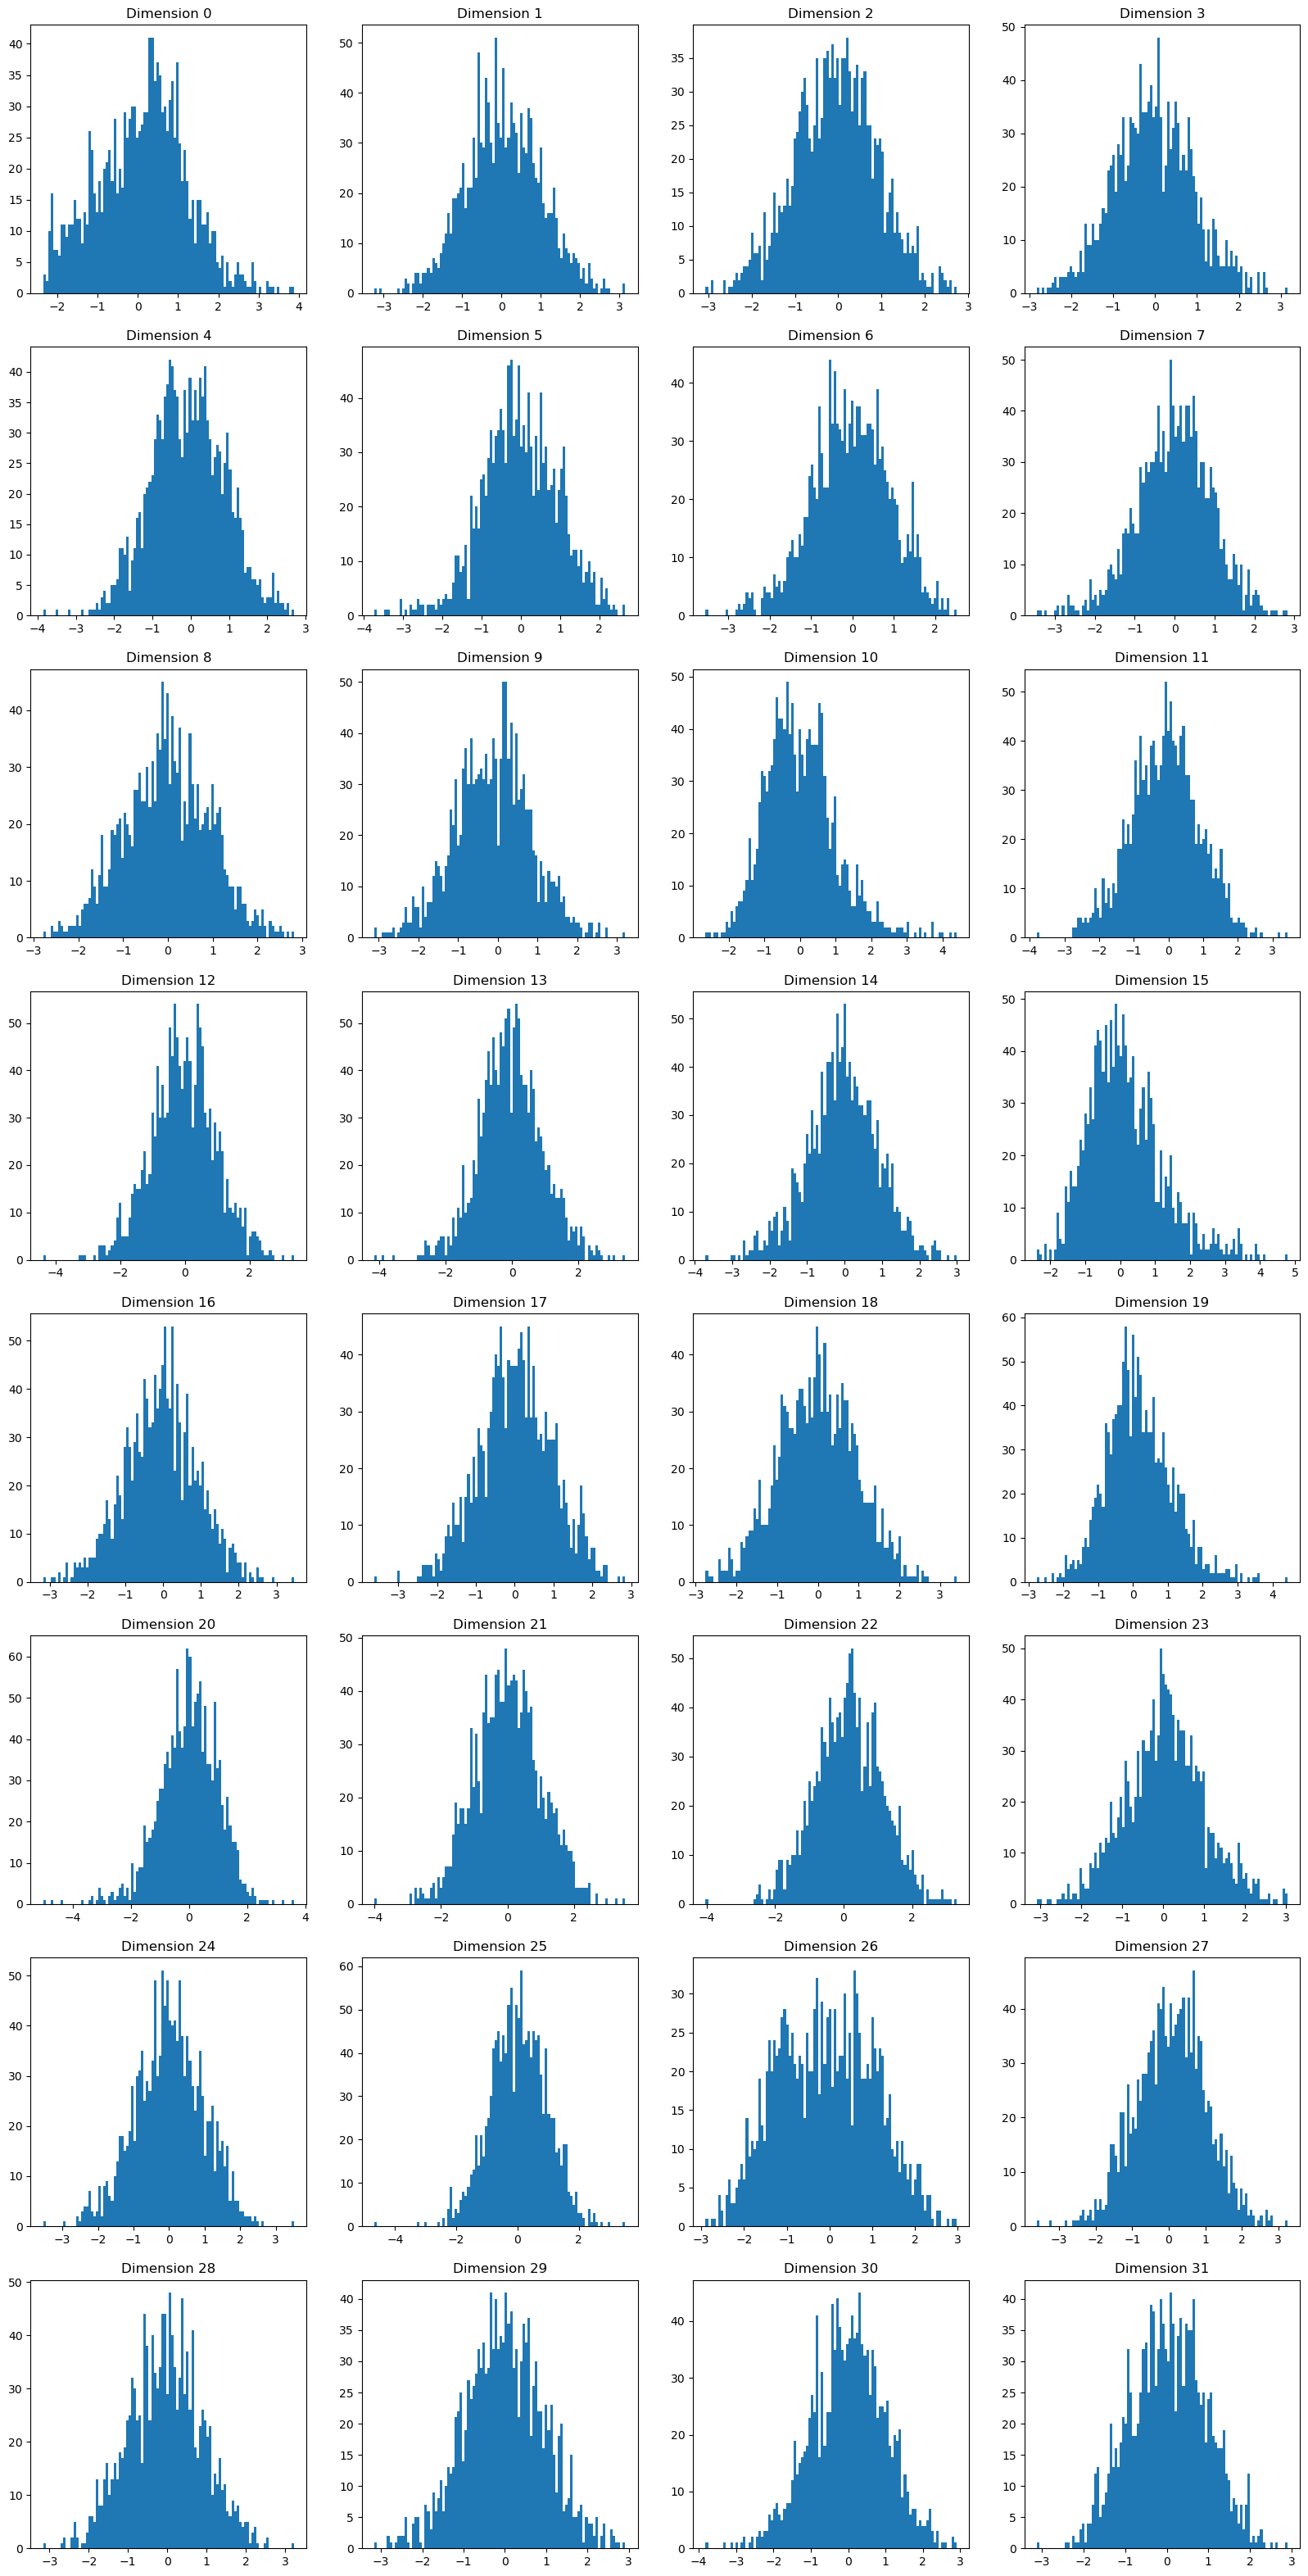

In [60]:
# Printing the representation of all the dimensions
fig, axs = plt.subplots(8, 4, figsize=(20,40))
for i in range(8):
    for j in range(4):
        axs[i,j].hist(z_list[:,i*4+j], bins=100)
        axs[i,j].set_title("Dimension " + str(i*4+j))
plt.show()

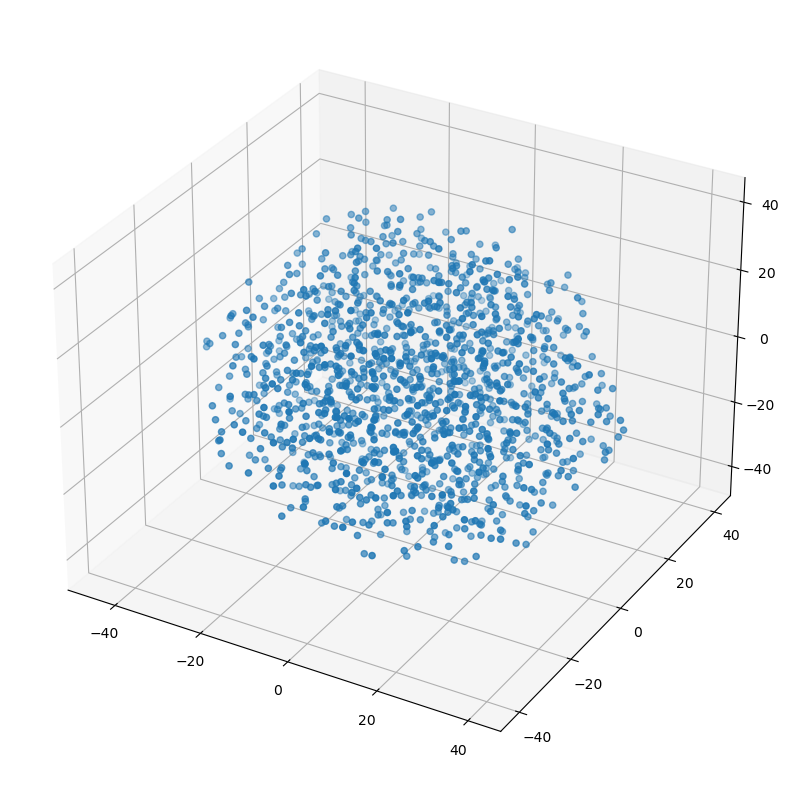

In [154]:
# Using TSNE to visualize the latent space, grouping the points by class
from sklearn.manifold import TSNE

tsne = TSNE(n_components=3, perplexity=50, n_iter=5000, random_state=0)
z_tsne = tsne.fit_transform(z_list)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(z_tsne[:,0], z_tsne[:,1], z_tsne[:,2])
plt.show()

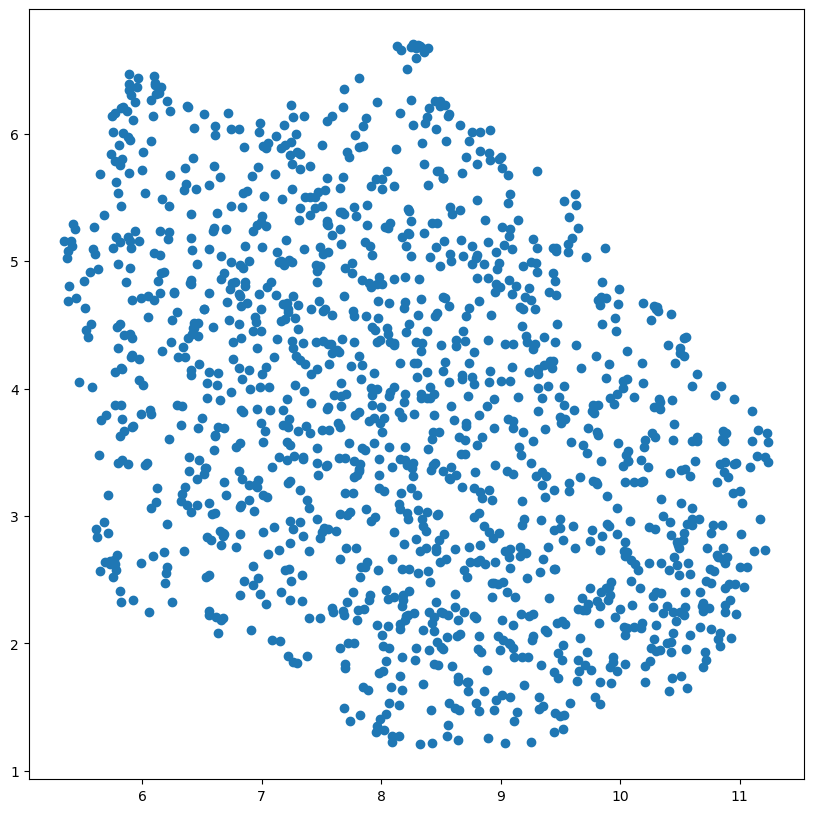

In [64]:
# Using UMAP to visualize the latent space
import umap

reducer = umap.UMAP()
z_umap = reducer.fit_transform(z_list)

plt.figure(figsize=(10,10))
plt.scatter(z_umap[:,0], z_umap[:,1])
plt.show()

In [69]:
z_dims = [torch.zeros(50, model.latent_dim) for i in range(7)]
z_umaps = []
dims = [0,26,15,20,10,19,30]
for i in range(7):
    z_dims[i][:,dims[i]] = torch.tensor(np.linspace(-3, 3, 50)).to(device)
    z_dims[i] = z_dims[i].cpu().detach().numpy()
    z_umaps.append(reducer.transform(z_dims[i]))

In [72]:
colors = np.random.rand(7,3)

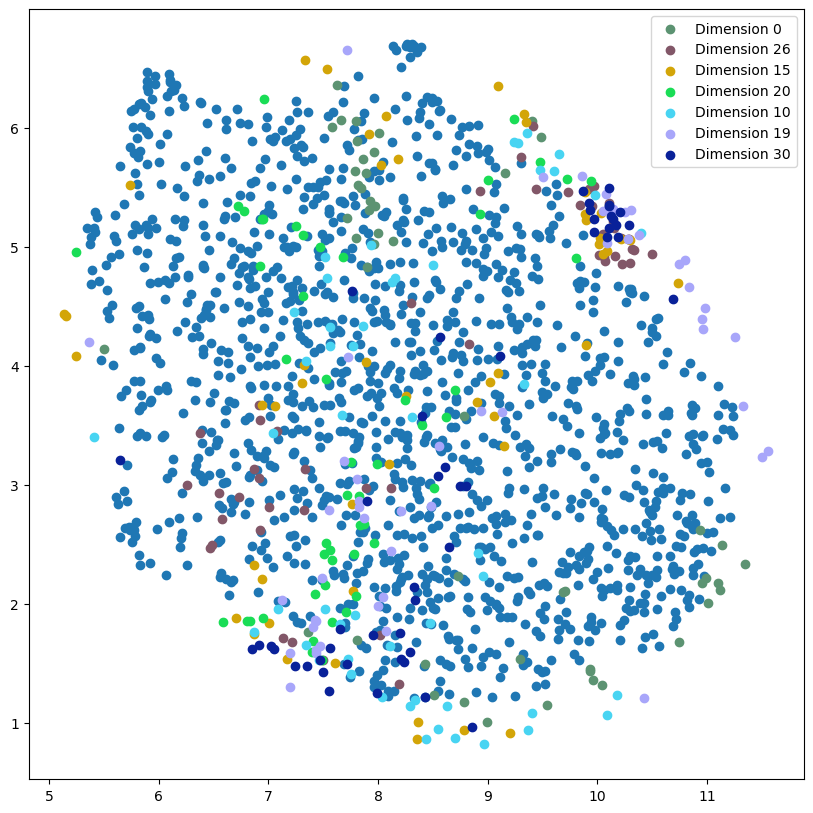

In [73]:
plt.figure(figsize=(10,10))
plt.scatter(z_umap[:,0], z_umap[:,1])
for i in range(7):
    plt.scatter(z_umaps[i][:,0], z_umaps[i][:,1], color=colors[i], label="Dimension " + str(dims[i]))
plt.legend()
plt.show()

In [ ]:
fig, ax = plt.subplots(8, 4, figsize=(20, 40))
for i in range(32):
  ax[i//4, i%4].hist(z_list[:,i], bins=100)
plt.show()

In [119]:
model_2_5 = VAE(4, 100, 32).to(device)
model_2_5.load_state_dict(torch.load('model_beta_2_5.pth'))
model_1 = VAE(4, 100, 32).to(device)
model_1.load_state_dict(torch.load('best_model_2.pth'))
model_500 = VAE(4, 100, 32).to(device)
model_500.load_state_dict(torch.load('model_beta_500.pth'))
model_750 = VAE(4, 100, 32).to(device)
model_750.load_state_dict(torch.load('model_beta_750.pth'))
model_900 = VAE(4, 100, 32).to(device)
model_900.load_state_dict(torch.load('model_beta_900.pth'))
model_1000 = VAE(4, 100, 32).to(device)
model_1000.load_state_dict(torch.load('worse_model_beta_1000.pth'))

<All keys matched successfully>

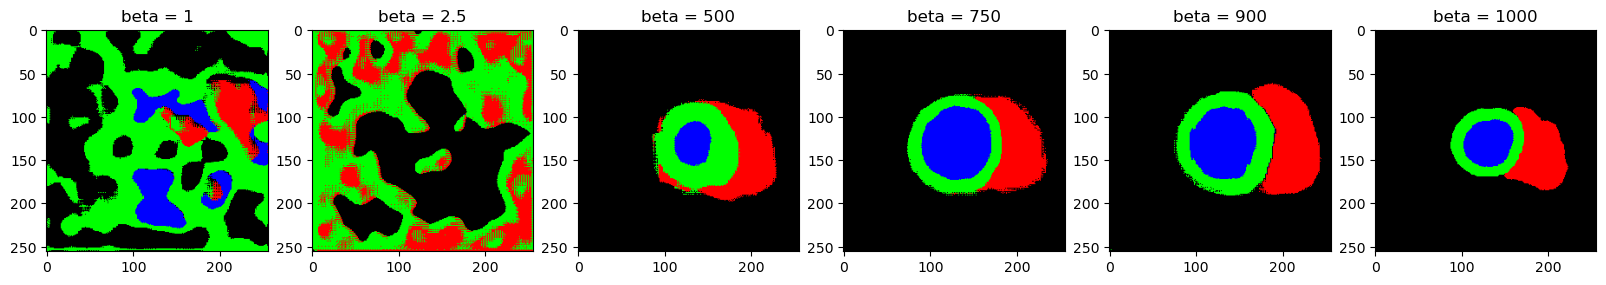

In [124]:
def generate_slices_models():
    eps = torch.randn(6, model.latent_dim).to(device)
    slices_generated = torch.zeros((6, 4, 256, 256)).to(device)
    slices_generated[0] = model_1.decoder(eps[0].unsqueeze(0))
    slices_generated[1] = model_2_5.decoder(eps[1].unsqueeze(0))
    slices_generated[2] = model_500.decoder(eps[2].unsqueeze(0))
    slices_generated[3] = model_750.decoder(eps[3].unsqueeze(0))
    slices_generated[4] = model_900.decoder(eps[4].unsqueeze(0))
    slices_generated[5] = model.decoder(eps[5].unsqueeze(0))
    return slices_generated

def display_slices_models(slices):
  c = slices.shape[0]
  new_slices = []
  legends = ["beta = 1", "beta = 2.5", "beta = 500", "beta = 750", "beta = 900", "beta = 1000"]
  figs, axs = plt.subplots(1,c, figsize=(20,5))
  dice_accuracy = 0
  for j in range(c):
    slices[j] = slices[j].softmax(dim=0)
    new_slices.append(torch.argmax(slices[j], dim=0))
    axs[j].imshow(four_channels(new_slices[j].cpu().detach().numpy())[:,:,1:])
    axs[j].set_title(legends[j])
  plt.show()

slices_generated = generate_slices_models()
display_slices_models(slices_generated)

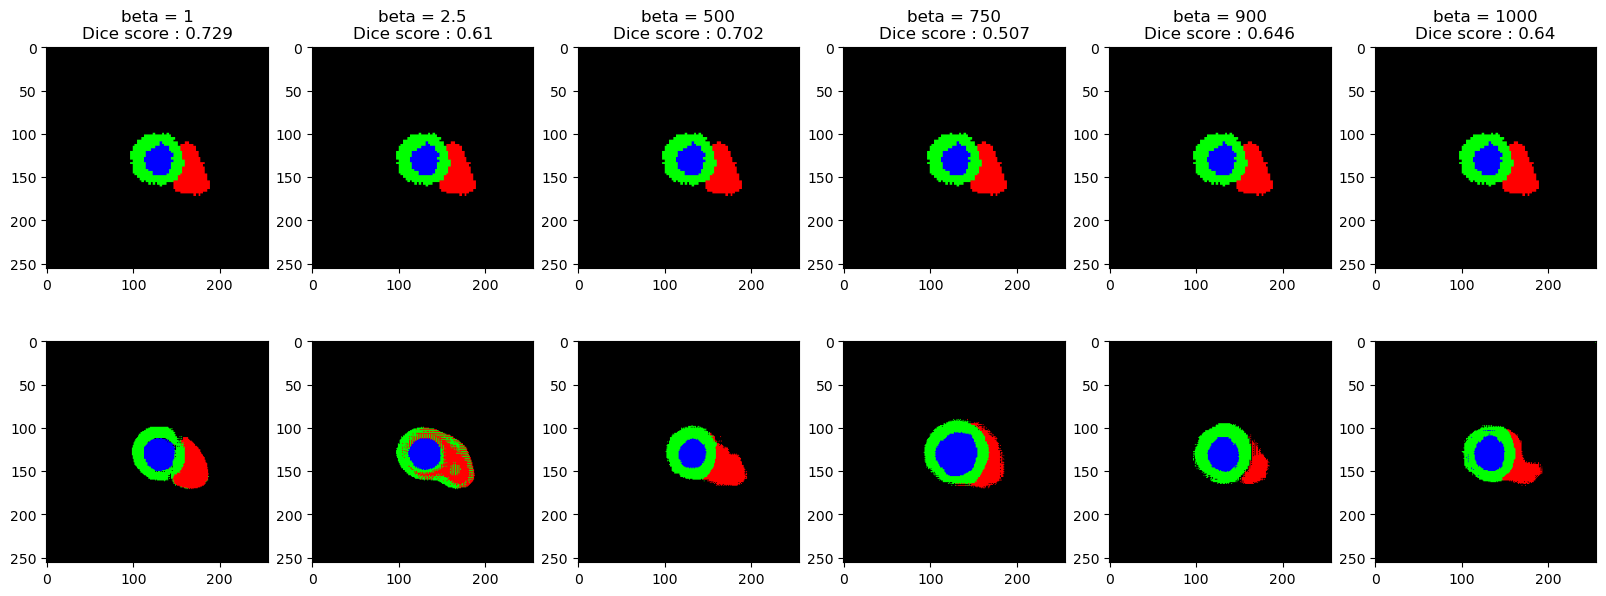

In [121]:
for batch in testloader:
  model.eval()
  data = batch[0][:2]
  fig, axs = plt.subplots(2, 6, figsize=(20,7))
  data_model = data.to(device)
  legends = ["beta = 1", "beta = 2.5", "beta = 500", "beta = 750", "beta = 900", "beta = 1000"]
  models = [model_1, model_2_5, model_500, model_750, model_900, model_1000]
  for i in range(6):
    y, z_mu, z_log_var = models[i].forward(data_model)
    dice_accuracy = calculate_dice_score(y, data_model, dice_metric)
    y_print = torch.squeeze(y)
    # make y_print between 0 and 1
    y_print = torch.argmax(y_print, dim=1, keepdim=True)
    y_print = y_print.permute(0, 2, 3, 1).squeeze(3).cpu().detach().numpy()
    axs[0,i].imshow(data[0].permute(1, 2, 0)[:,:,1:])
    y_print_ = four_channels(y_print[0])
    axs[1,i].imshow(y_print_[:,:,1:])
    axs[0,i].set_title(legends[i] + "\nDice score : " + str(round(dice_accuracy.mean().item(), 3)))
  plt.show()
  break

In [138]:
# fitting a gaussian distribution to the latent space
z_list_500 = []
for batch in trainloader:
  model_1.eval()
  data = batch[0]
  data_model = data.to(device)
  y, z_mu, z_log_var = model_1.forward(data_model)
  z = model_1.sampling(z_mu, z_log_var)
  z_list_500.append(z.detach().cpu().numpy())

z_list_500 = np.concatenate(z_list_500, axis=0)

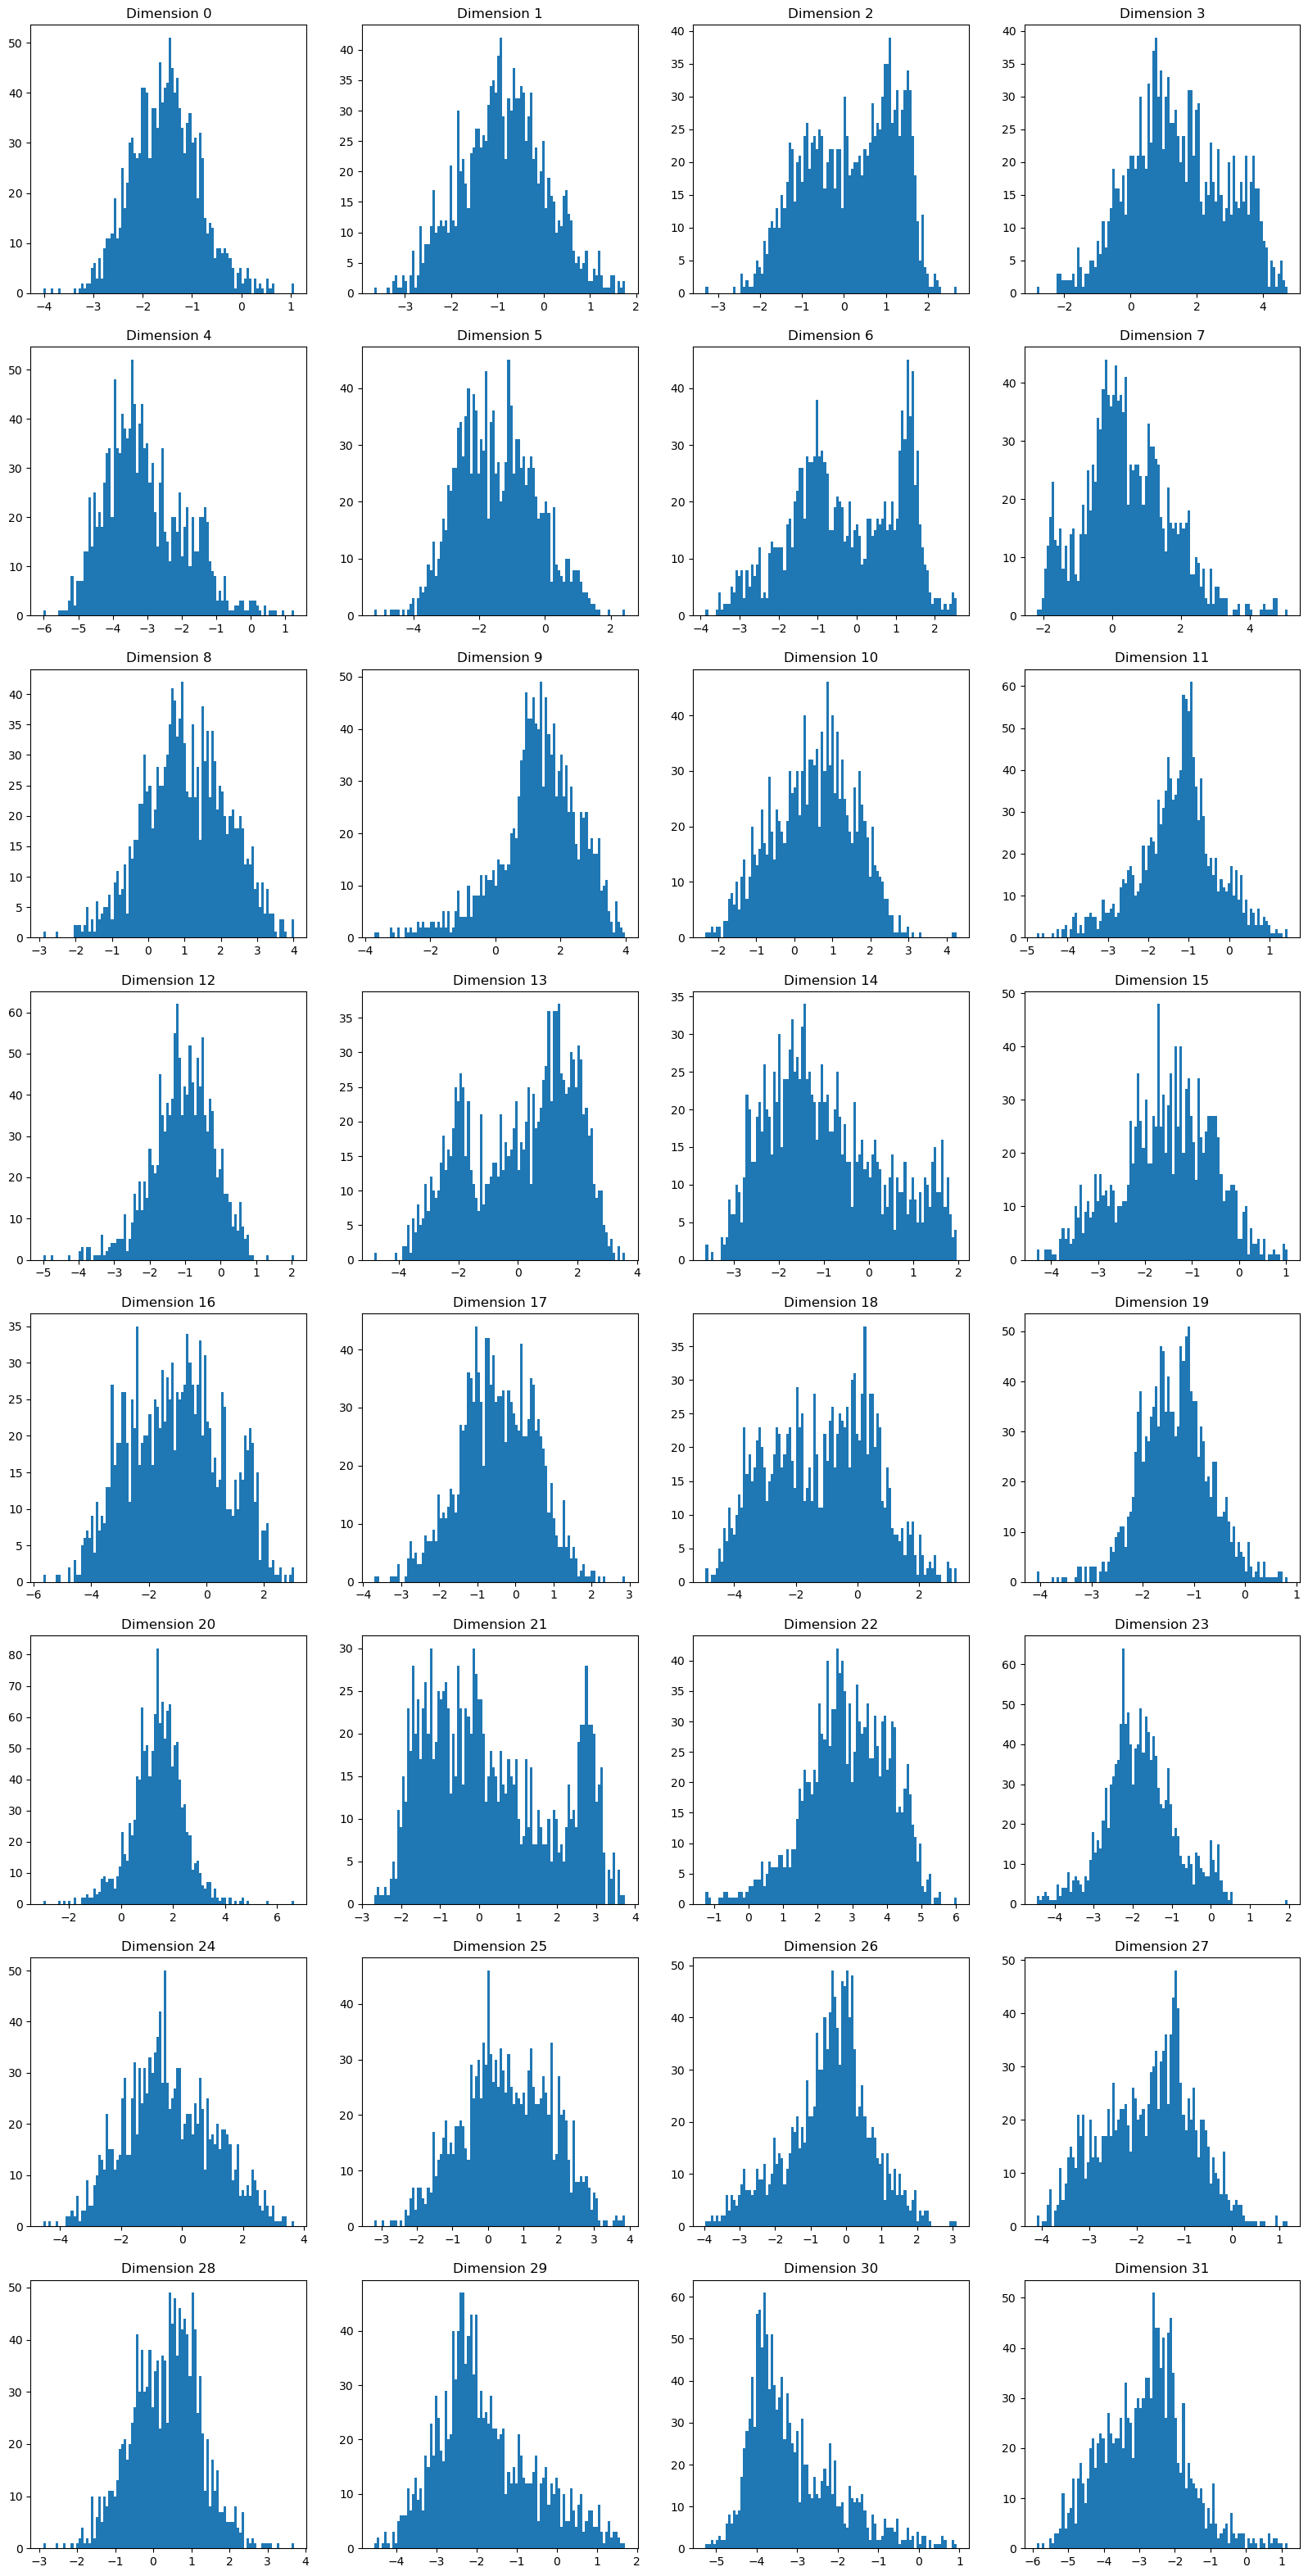

In [139]:
# Printing the representation of all the dimensions
fig, axs = plt.subplots(8, 4, figsize=(20,40))
for i in range(8):
    for j in range(4):
        axs[i,j].hist(z_list_500[:,i*4+j], bins=100)
        axs[i,j].set_title("Dimension " + str(i*4+j))
plt.show()

In [143]:
reducer_500 = umap.UMAP()
z_umap_500 = reducer.fit_transform(z_list_500)

<Figure size 1000x1000 with 0 Axes>

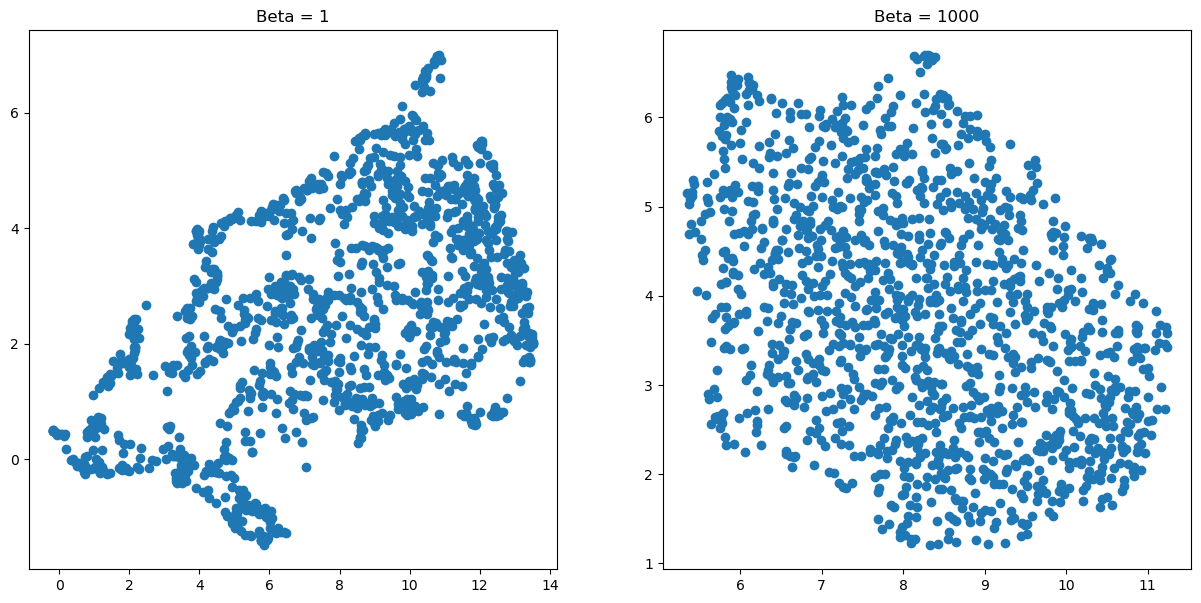

In [146]:
plt.figure(figsize=(10,10))
figs, axs = plt.subplots(1,2, figsize=(15,7))
axs[0].scatter(z_umap_500[:,0], z_umap_500[:,1])
axs[0].set_title("Beta = 1")
axs[1].scatter(z_umap[:,0], z_umap[:,1])
axs[1].set_title("Beta = 1000")
plt.show()